In [1]:
import os
import sys
import pickle
import numpy as np
import scipy as sc
from subprocess import call
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import time

In [3]:
batch_size = 64
epochs = 10000
seed = 1
lr = 0.01
momentum = 0.5
log_interval = 10
PATH = "model" # model path
cuda = torch.cuda.is_available()

if cuda:
    torch.cuda.manual_seed(seed)

In [4]:
train_loader = torch.utils.data.DataLoader(
                datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
                batch_size=batch_size, shuffle=True)

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320) # flatten
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x) # transform to logits

In [6]:
model = CNN()
if cuda:
    model.cuda()
print (model)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
print (optimizer)

CNN (
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d (p=0.5)
  (fc1): Linear (320 -> 50)
  (fc2): Linear (50 -> 10)
)


In [7]:
loss_history = []
normgrad_history = []

In [8]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        
        data, target = Variable(data), Variable(target)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        #'''
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]), end='\r')
        #'''
        return loss.data[0]

In [9]:
def cal_norm_grad():
    grad_all = 0.0
    for p in model.parameters():
        grad = 0.0
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy() ** 2).sum()
        grad_all += grad
    grad_norm = grad_all ** 0.5
    return grad_norm

In [10]:
for epoch in range(epochs):
    loss = train(epoch)
    #test(epoch)
    normgrad = cal_norm_grad()
    normgrad_history.append(normgrad)
    loss_history.append(loss)

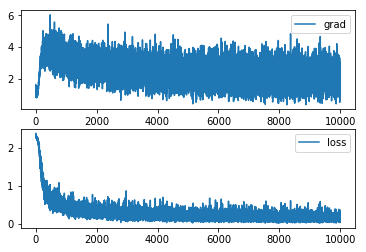

In [11]:
plt.clf
plt.subplot(211)
e = list(range(len(normgrad_history)))
plt.plot(e, normgrad_history, label="grad")
plt.legend()
plt.subplot(212)
e = list(range(len(loss_history)))
plt.plot(e, loss_history, label="loss")
plt.legend()
plt.savefig('grad_loss.png')
plt.show()

In [ ]:
plt.subplot(211)
e = list(range(len(normgrad_history)))
plt.plot(e, normgrad_history, label="grad")
plt.legend()
plt.subplot(212)
e = list(range(len(loss_history)))
plt.plot(e, loss_history, label="loss")
plt.legend()
plt.show()
plt.savefig('grad_loss.png')